In [11]:
%load_ext autoreload
%autoreload 2
from load import *
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import load
import torch
from liftpose.vision_3d import XY_coord_dict, Z_coord_dict

reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir' : '/data/LiftPose3D/mouse_prism', # change the path 
       'out_dir'        : './out',
       'train_subjects' : ['G6AE1','G6AE2','G6AE3','G6AE5'],
       'test_subjects'  : ['G6AE6'],
       'actions'        : ['control']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load data
train, train_keypts, _ = load.load_3D(par['data_dir'], subjects=par['train_subjects'], actions=par['actions'])
test,  test_keypts, _ = load.load_3D(par['data_dir'], subjects=par['test_subjects'],  actions=par['actions'])
# project data
train_2d, train_3d = XY_coord_dict(train), Z_coord_dict(train)
test_2d, test_3d  = XY_coord_dict(test), Z_coord_dict(test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'])

[main.py:187]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/mouse_prism/out/stat_2d.pth.tar.
[main.py:216]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/mouse_prism/outstat_3d.pth.tar.
[main.py:237]:INFO:Starting training model.
[main.py:244]:DEBUG:
==================Options=================
[main.py:245]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/mouse_prism/out',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/mouse_prism/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/mouse_prism/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:246]:DEBUG:=============================

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  2.26609|: 100%|██████████| 523/523 [00:12<00:00, 41.25it/s]
Epoch 001 | LR  0.00100 | Loss Test  1.28210 | Loss Train  0.99630|: 100%|██████████| 523/523 [00:11<00:00, 46.03it/s]
Epoch 002 | LR  0.00100 | Loss Test  1.54332 | Loss Train  0.88267|: 100%|██████████| 523/523 [00:12<00:00, 43.46it/s]
Epoch 003 | LR  0.00100 | Loss Test  1.52709 | Loss Train  0.86058|: 100%|██████████| 523/523 [00:11<00:00, 44.17it/s]
Epoch 004 | LR  0.00100 | Loss Test  1.33170 | Loss Train  0.83079|: 100%|██████████| 523/523 [00:12<00:00, 41.72it/s]
Epoch 005 | LR  0.00100 | Loss Test  1.33045 | Loss Train  0.80749|: 100%|██████████| 523/523 [00:11<00:00, 44.51it/s]
Epoch 006 | LR  0.00100 | Loss Test  1.26249 | Loss Train  0.78268|: 100%|██████████| 523/523 [00:11<00:00, 43.98it/s]
Epoch 007 | LR  0.00100 | Loss Test  1.13308 | Loss Train  0.76321|: 100%|██████████| 523/523 [00:12<00:00, 42.48it/s]
Epoch 008 | LR  0.00100 | Loss Test  1.78771 | L

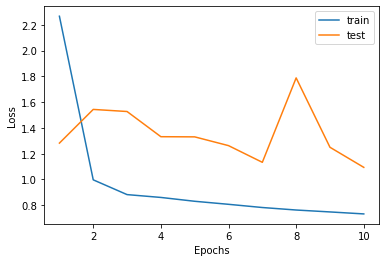

In [14]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

In [15]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:268]:INFO:starting testing in path: ./out
[lift.py:29]:INFO:Training on the device: cuda:0
[lift.py:57]:INFO:total params: 4.23M
[lift.py:63]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:71]:INFO:ckpt loaded (epoch: 10 | err: 2.1332210742428312)
[lift.py:109]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/mouse_prism/out/test_results.pth.tar


In [23]:
from liftpose.postprocess import load_test_results
data = torch.load(par['out_dir'] + "/test_results.pth.tar")
stat_2d, stat_3d = (
    torch.load(par['out_dir'] + "/stat_2d.pth.tar"),
    torch.load(par['out_dir'] + "/stat_3d.pth.tar"),
)
test_3d_gt, test_3d_pred, good_keypts  = load_test_results(data, stat_2d, stat_3d)

In [37]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
#%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=200, azim=60)

t = 0
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t], show_gt_always=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …